<a href="https://colab.research.google.com/github/dnezan/km-sku-prediction/blob/main/KM_forecast_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **KwickMetrics Forecast Practice**
Dinesh Sreekanthan<br>
https://github.com/dnezan/km-sku-prediction

# Data Overview
The dataset has 3 columns
<br>
*   SKU ID
*   Date
*   Number of items sold that day

By using the function `=COUNTUNIQUE(A:A)` in Google Spreadsheets or `Dataframe.unique()` in Pandas, we can find the number of unique items being sold. <br>

**There are 3 unique items being sold over a period of about 67 months (2016-05-08 - 2021-12-06)**

# Setting up Cloud Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd "/content/drive/My Drive"

/content/drive/My Drive


In [3]:
!mkdir km-forecast-practice

mkdir: cannot create directory ‘km-forecast-practice’: File exists


In [4]:
%cd "/content/drive/My Drive/km-forecast-practice"

/content/drive/My Drive/km-forecast-practice


Make sure to move your dataset `km-forecast-practice.csv` to this folder.

In [5]:
!ls

amazon.com-2016-masked.csv		graph.png
amazon.com-2016-masked-datef.csv	graph.svg
daily_data_processed.csv		graph_total.png
dataset-day-wise-amazon.com-masked.csv	graph_total.svg
dataset_new.csv				km-forecast-practice-data.csv
dataset_new.gsheet			OLD_km-forecast-practice-data.csv
graph2.png				temppp.csv
graph3.png


In [6]:
import pandas as pd
import csv
import datetime

dataset_name = 'dataset-day-wise-amazon.com-masked.csv'
df=pd.read_csv(dataset_name)
df['timestamp']= pd.to_datetime(df['timestamp'])
print(df.dtypes)
df.head()

item_id               int64
timestamp    datetime64[ns]
demand                int64
dtype: object


,item_id,timestamp,demand
0,528,2016-05-08,0
1,528,2016-05-09,0
2,528,2016-05-10,0
3,528,2016-05-11,1
4,528,2016-05-12,2


# Preprocessing the Data
The first step is to rearrange the data so that we have each column representing a day and the rows containing the SKU ID. <br> 
We must also populate the data with missing dates, which we assume have 0 items sold on that day. So the first step is to add the missing dates, then set these as 0.

In [7]:
from dateutil.relativedelta import *

start_date=df.timestamp[0].date()  
end_date=df.timestamp.iat[-1].date()
start_sku=df.item_id[1]
print('Start date is',start_date)
print('End date is',end_date)
print("First SKU is",start_sku)

data = [[start_sku, 0]]

# Populating the new dataset with first row
df_new = pd.DataFrame(data, columns = ['SKU', start_date])
x = start_date

index = 2
var=0
num_months = (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month)
num_days = (end_date-start_date).days

print("There are", num_months, "months between the two dates")
print("There are", num_days, "days between the two dates")

choice_num = input("Is your data daily or monthly? (d/m) ")
if (choice_num == 'd'):
  num_var = num_days
elif (choice_num == 'm'):
  num_var = num_months



while var<num_var:
  if (choice_num == 'd'):
    x+= datetime.timedelta(days=1)
  elif (choice_num == 'm'):
      x = x + relativedelta(months=+1)
  df_new.insert(loc=index, column=x, value=0)
  index+=1
  var+=1
year_mark = df_new
df_new.head()



Start date is 2016-05-08
End date is 2021-12-06
First SKU is 528
There are 67 months between the two dates
There are 2038 days between the two dates
Is your data daily or monthly? (d/m) d


,SKU,2016-05-08,2016-05-09,2016-05-10,2016-05-11,2016-05-12,2016-05-13,2016-05-14,2016-05-15,2016-05-16,2016-05-17,2016-05-18,2016-05-19,2016-05-20,2016-05-21,2016-05-22,2016-05-23,2016-05-24,2016-05-25,2016-05-26,2016-05-27,2016-05-28,2016-05-29,2016-05-30,2016-05-31,2016-06-01,2016-06-02,2016-06-03,2016-06-04,2016-06-05,2016-06-06,2016-06-07,2016-06-08,2016-06-09,2016-06-10,2016-06-11,2016-06-12,2016-06-13,2016-06-14,2016-06-15,...,2021-10-28,2021-10-29,2021-10-30,2021-10-31,2021-11-01,2021-11-02,2021-11-03,2021-11-04,2021-11-05,2021-11-06,2021-11-07,2021-11-08,2021-11-09,2021-11-10,2021-11-11,2021-11-12,2021-11-13,2021-11-14,2021-11-15,2021-11-16,2021-11-17,2021-11-18,2021-11-19,2021-11-20,2021-11-21,2021-11-22,2021-11-23,2021-11-24,2021-11-25,2021-11-26,2021-11-27,2021-11-28,2021-11-29,2021-11-30,2021-12-01,2021-12-02,2021-12-03,2021-12-04,2021-12-05,2021-12-06
0,528,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Now we add all the unique products and populate the Dataframe with 0s. (Takes a few minutes to complete)

In [8]:
print(df_new.shape[1]) #number of columns

uniqval = list(df.item_id.unique()) #list of unique products
uniqval.pop(0)

x=0
while x < len(uniqval):
  listofzeros = [0] * (num_var + 1)
  listofzeros.insert(0, uniqval[x])
  df_length = len(df_new)
  df_new.loc[df_length] = listofzeros
  x+=1
  if(x%200==0):
    print(x)

print(df_new)

2040
    SKU  2016-05-08  2016-05-09  ...  2021-12-04  2021-12-05  2021-12-06
0   528           0           0  ...           0           0           0
1   529           0           0  ...           0           0           0
2  2336           0           0  ...           0           0           0

[3 rows x 2040 columns]


Next we fill in the values of items that were actually sold on a given day.

In [9]:
uniqval.insert(0,start_sku)
#print(uniqval)

In [10]:
#Adding first product sales
count=-1

for y in uniqval:
  for x in df.item_id:
    if x == y: 
      count+=1
      z=df_new.columns.get_loc(pd.to_datetime(df.timestamp[count].date()).date())
      z1=df_new.index.get_loc(df_new.index[df_new['SKU'] == x][0])
      df_new.iloc[z1,z] = df.demand[count]
      
print("This product was sold on",count,"days")
df_new.head()

#Adding the rest of the product sales 

This product was sold on 5693 days


,SKU,2016-05-08,2016-05-09,2016-05-10,2016-05-11,2016-05-12,2016-05-13,2016-05-14,2016-05-15,2016-05-16,2016-05-17,2016-05-18,2016-05-19,2016-05-20,2016-05-21,2016-05-22,2016-05-23,2016-05-24,2016-05-25,2016-05-26,2016-05-27,2016-05-28,2016-05-29,2016-05-30,2016-05-31,2016-06-01,2016-06-02,2016-06-03,2016-06-04,2016-06-05,2016-06-06,2016-06-07,2016-06-08,2016-06-09,2016-06-10,2016-06-11,2016-06-12,2016-06-13,2016-06-14,2016-06-15,...,2021-10-28,2021-10-29,2021-10-30,2021-10-31,2021-11-01,2021-11-02,2021-11-03,2021-11-04,2021-11-05,2021-11-06,2021-11-07,2021-11-08,2021-11-09,2021-11-10,2021-11-11,2021-11-12,2021-11-13,2021-11-14,2021-11-15,2021-11-16,2021-11-17,2021-11-18,2021-11-19,2021-11-20,2021-11-21,2021-11-22,2021-11-23,2021-11-24,2021-11-25,2021-11-26,2021-11-27,2021-11-28,2021-11-29,2021-11-30,2021-12-01,2021-12-02,2021-12-03,2021-12-04,2021-12-05,2021-12-06
0,528,0,0,0,1,2,2,2,1,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,14,19,15,17,16,18,21,13,18,16,10,273,352,5,25,30,37,42,17,10,19,9,21,33,23,24,18,21,20,54,52,40,123,53,23,22,34,52,46,40
1,529,1,0,0,0,2,0,1,0,2,0,1,1,0,1,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,5,3,8,4,5,4,3,3,3,10,28,11,8,4,7,9,6,10,7,6,9,11,5,3,12,4,6,7,16,12,23,15,5,5,4,10,3,7
2,2336,0,0,1,0,0,0,1,1,0,1,2,0,1,0,0,1,2,1,0,0,1,0,0,0,1,1,0,0,0,0,20,40,0,1,2,0,0,2,0,...,24,19,16,20,23,23,21,23,19,17,28,24,37,23,29,35,33,41,37,38,39,42,39,33,41,53,49,33,37,86,84,67,84,57,18,18,49,62,59,39


In [11]:
df_new.to_csv('dataset_new.csv')

# Visualisation
Here we can visualise the sales of the first product in our dataset over a year.


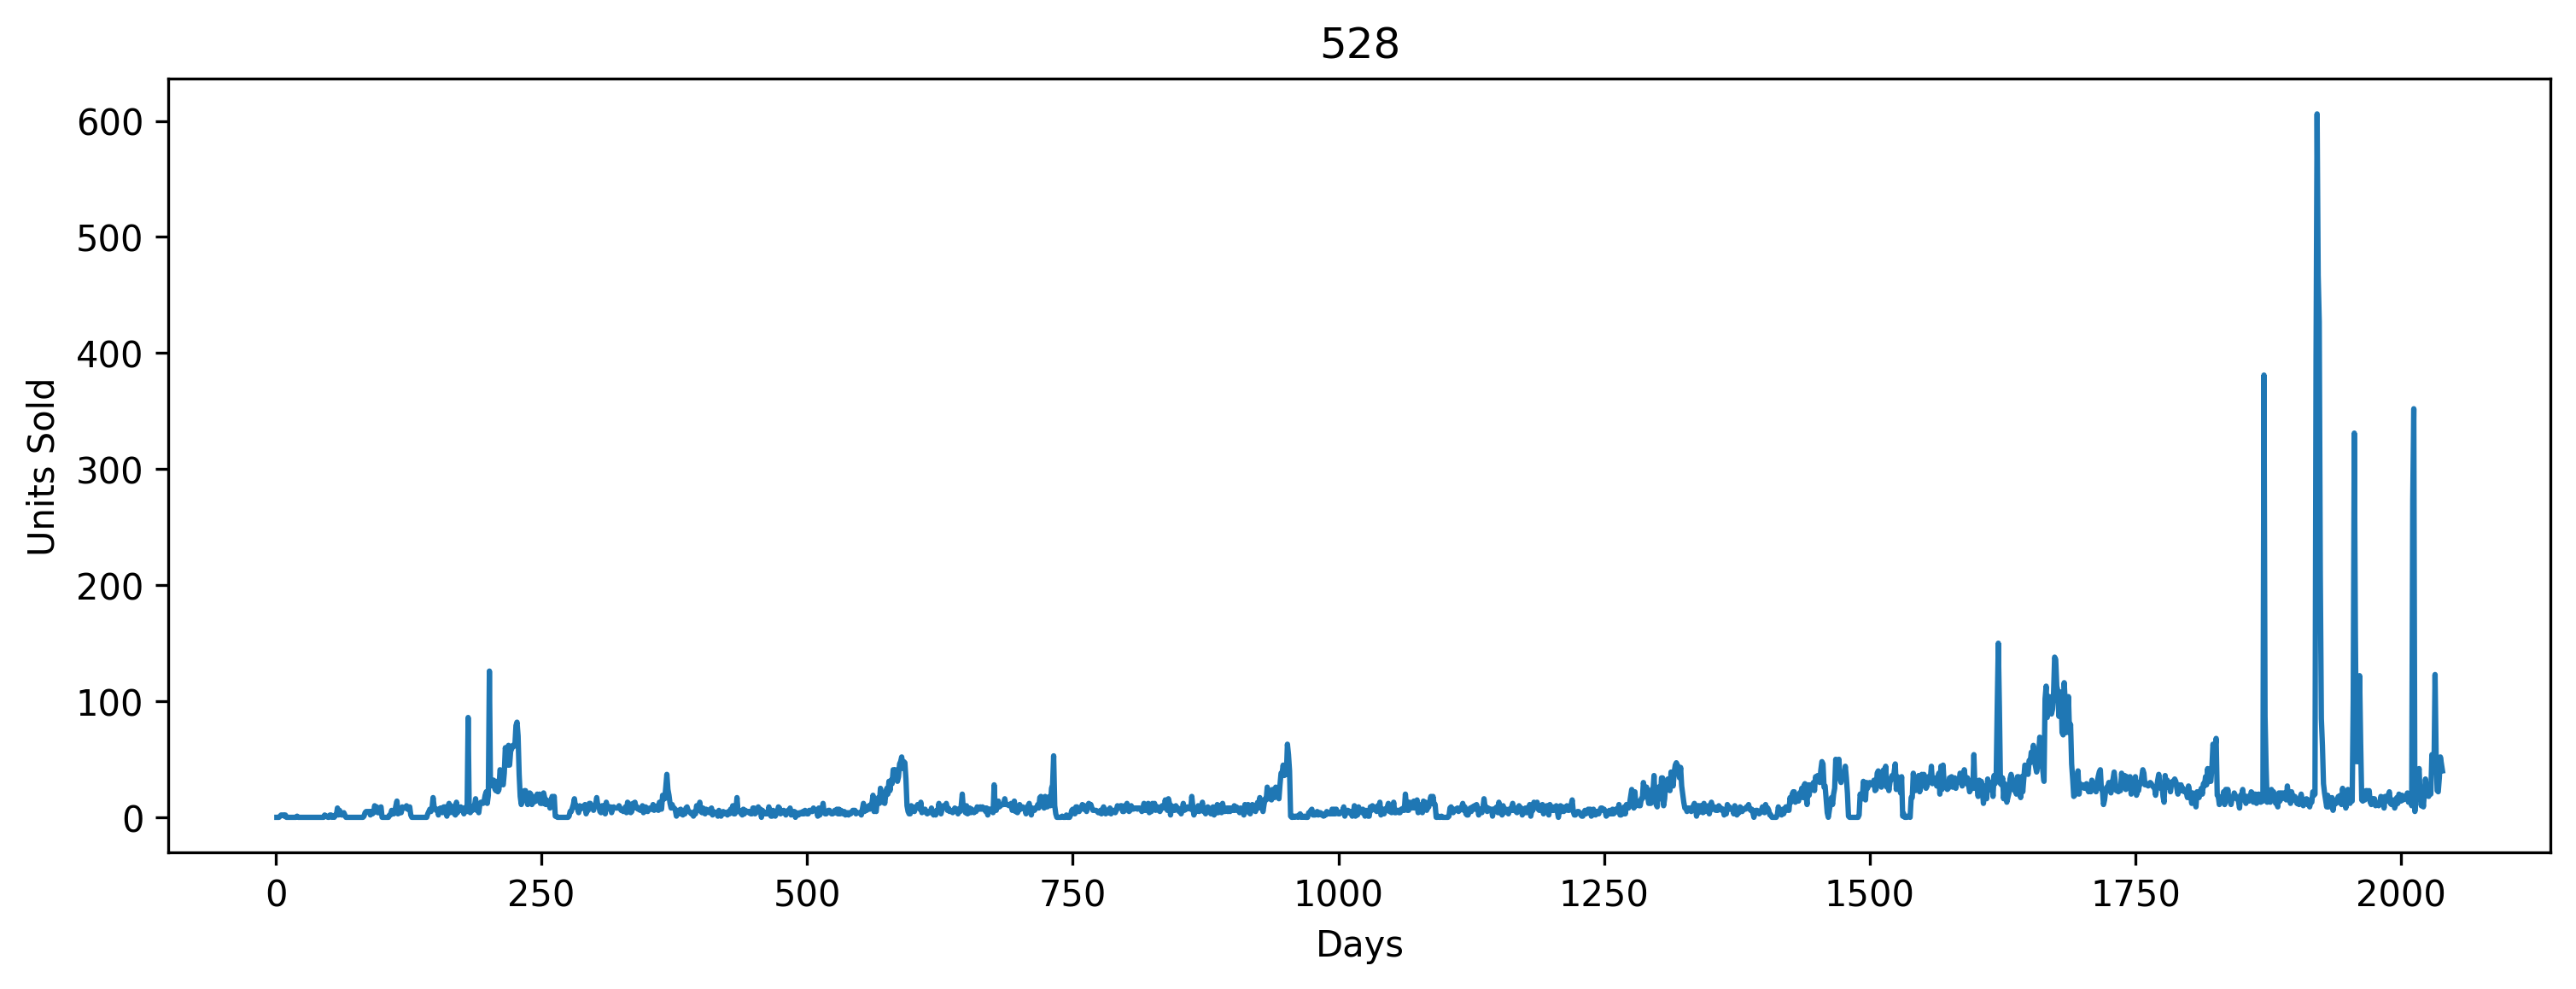

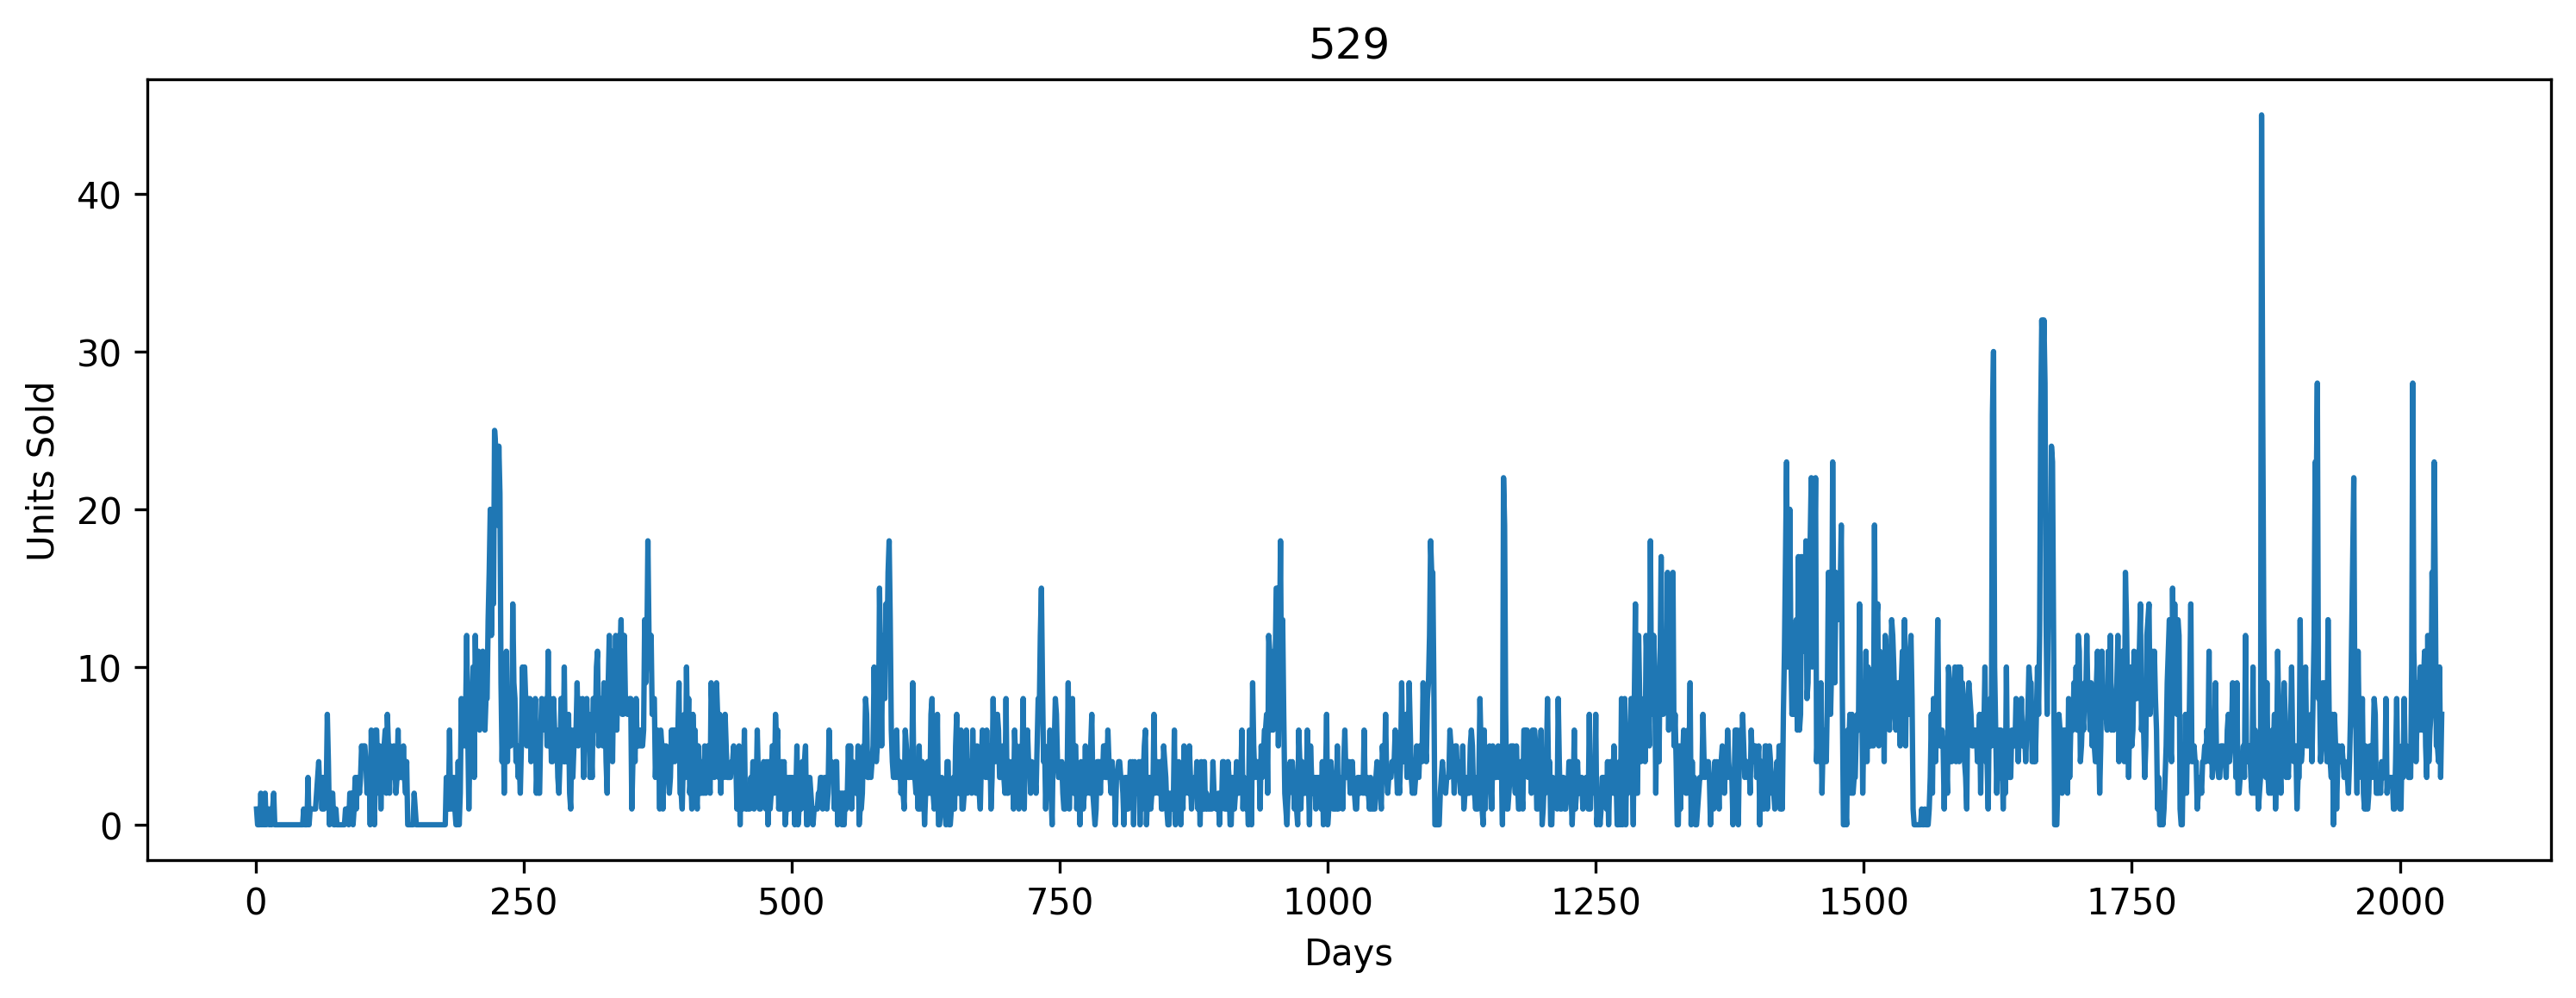

In [12]:
###MATPLOTLIB

import matplotlib.pyplot as plt
import numpy as np

#Enter random SKU here
a=0
b=1
c=2

##Plotting first product
temp = df_new.iloc[a].tolist()
del temp[0]

xpoints =range(1, (num_var+2))
xpoints=list(xpoints)
plotly_x=temp  
f = plt.figure(dpi=300)
f.set_figwidth(12)
f.set_figheight(4)
plt.plot(xpoints, temp)
if(choice_num=='d'):
  plt.xlabel('Days')
if(choice_num=='m'):
  plt.xlabel('Months')
plt.ylabel('Units Sold')
plt.title(df_new.SKU[a])

##Plotting second product
temp = df_new.iloc[b].tolist()
del temp[0]
plotly_y = temp 
xpoints =range(1, num_var+2)
xpoints=list(xpoints)

f = plt.figure(dpi=300)
f.set_figwidth(12)
f.set_figheight(4)
plt.plot(xpoints, temp)

if(choice_num=='d'):
  plt.xlabel('Days')
if(choice_num=='m'):
  plt.xlabel('Months')
plt.ylabel('Units Sold')
plt.title(df_new.SKU[b])


##Plotting third product
temp = df_new.iloc[c].tolist()
del temp[0]
plotly_z = temp 
xpoints =range(1, num_var+2)
xpoints=list(xpoints)

f = plt.figure(dpi=300)
f.set_figwidth(12)
f.set_figheight(4)
plt.plot(xpoints, temp)
if(choice_num=='d'):
  plt.xlabel('Days')
if(choice_num=='m'):
  plt.xlabel('Months')
plt.ylabel('Units Sold')
plt.title(df_new.SKU[c])

#plt.savefig("graph_total.png") #PNG saved to Drive
#plt.savefig("graph_total.svg") #Lossless SVG saved to Drive
#plt.show()
plt.close()


In [13]:
###PLOTLY

import math
from math import log, floor
import pywt
from statsmodels.robust import mad
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots


fig = make_subplots(rows=3, cols=1)

###set marker for every year start

marker_color= "gainsboro"

date_dict = year_mark.columns

print("date dict is:", date_dict)

#1st graph marker
p = year_mark.columns
p = p.tolist()
del p[0]
x = 0
for every_val in p:
  if "01-01" not in p[x].strftime("%Y-%m-%d"):
    p[x]=0   
  else:
    p[x]=max(plotly_x)
  x+=1
fig.add_trace(
    go.Scatter(x=np.arange(len(p)), mode='lines', y=p, marker=dict(color=marker_color), showlegend=False,
               name="Years"),
    row=1, col=1
)

#2nd graph marker
p = year_mark.columns
p = p.tolist()
del p[0]
x = 0
for every_val in p:
  if "01-01" not in p[x].strftime("%Y-%m-%d"):
    p[x]=0  
  else:
    p[x]=max(plotly_y)
  x+=1
fig.add_trace(
    go.Scatter(x=np.arange(len(p)), mode='lines', y=p, marker=dict(color=marker_color), showlegend=False,
               name="Years"),
    row=2, col=1
)

#3rd graph marker
p = year_mark.columns
p = p.tolist()
del p[0]
x = 0
for every_val in p:
  if "01-01" not in p[x].strftime("%Y-%m-%d"):
    p[x]=0 
  else:
    p[x]=max(plotly_z)
  x+=1

fig.add_trace(
    go.Scatter(x=np.arange(len(p)), mode='lines', y=p, marker=dict(color=marker_color), showlegend=False,
               name="Years"),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Original sales", plot_bgcolor="whitesmoke", xaxis=dict(
        title="timestamp",
        linecolor="#BCCCDC",  # Sets color of X-axis line
        showgrid=False  # Removes X-axis grid lines
    ),
    yaxis=dict(
        title="demand",  
        linecolor="#BCCCDC",  # Sets color of Y-axis line
        showgrid=False,  # Removes Y-axis grid lines    
    ))


fig.update_traces(line=dict(color=marker_color, width=0.7))


## Plot datapoints
fig.add_trace(
    go.Scatter(x=np.arange(len(plotly_x)), mode='lines', y=plotly_x, marker=dict(color="darkgreen"), showlegend=False,
               name="Original sale"),
    row=1, col=1
)


fig.add_trace(
    go.Scatter(x=np.arange(len(plotly_y)), mode='lines', y=plotly_y, marker=dict(color="purple"), showlegend=False,
               name="Original sale"),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(plotly_z)), mode='lines', y=plotly_z, marker=dict(color="navy"), showlegend=False,
               name="Original sale"),
    row=3, col=1
)

fig.update_traces(line=dict(width=1.5))

fig.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


date dict is: Index([     'SKU', 2016-05-08, 2016-05-09, 2016-05-10, 2016-05-11, 2016-05-12,
       2016-05-13, 2016-05-14, 2016-05-15, 2016-05-16,
       ...
       2021-11-27, 2021-11-28, 2021-11-29, 2021-11-30, 2021-12-01, 2021-12-02,
       2021-12-03, 2021-12-04, 2021-12-05, 2021-12-06],
      dtype='object', length=2040)


# Wavelet Denoising 
Since the daily data is high frequency and very noisy, we can denoise the data to make it easier to understand from an analyst's perpspective.

*   DWT Denoising
*   Binning into weeks/months



# DWT denoising 
https://en.wikipedia.org/wiki/Wavelet

In [14]:
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise_signal(x, wavelet='db4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    return pywt.waverec(coeff, wavelet, mode='per')

temp = df_new.iloc[a].tolist()
del temp[0]
x_1=temp

temp = df_new.iloc[b].tolist()
del temp[0]
x_2=temp

temp = df_new.iloc[c].tolist()
del temp[0]
x_3=temp

y_w1 = denoise_signal(x_1)
y_w2 = denoise_signal(x_2)
y_w3 = denoise_signal(x_3)

#remove every negative value
del_var = 0
while del_var < len(y_w1):
  if y_w1[del_var]<0:
    y_w1[del_var] = 0
  del_var+=1

del_var = 0
while del_var < len(y_w2):
  if y_w2[del_var]<0:
    y_w2[del_var] = 0
  del_var+=1

del_var = 0
while del_var < len(y_w3):
  if y_w3[del_var]<0:
    y_w3[del_var] = 0
  del_var+=1

#plotting the subplots
fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_1)), mode='lines', y=x_1, marker=dict(color="mediumaquamarine"), showlegend=False,
               name="Original signal"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_1)), y=y_w1, mode='lines', marker=dict(color="darkgreen"), showlegend=False,
               name="Denoised signal"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_2)), mode='lines', y=x_2, marker=dict(color="thistle"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_2)), y=y_w2, mode='lines', marker=dict(color="purple"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_3)), mode='lines', y=x_3, marker=dict(color="lightskyblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_3)), y=y_w3, mode='lines', marker=dict(color="navy"), showlegend=False),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Original (pale) vs. Denoised (dark) sales")
fig.show()

# Binning

# **Modeling**

# Splitting Train-Validation-Test Models<br>
We can choose to train on the first 90 days of the dataset and then predict the next 30 days after that. This prediction can be validated with our validation set of 30 days after the training dataset.

In [15]:
sales_train_val = pd.read_csv('dataset_new.csv')
ids = sorted(list(set(sales_train_val['SKU'])))
d_cols = [c for c in sales_train_val.columns]


train_range_start=2   
train_range_end=2000
validate_range_start=2000
validate_range_end=2041 #(no_days + 3. 2041)

train_dataset = sales_train_val[d_cols[train_range_start:train_range_end]]
val_dataset = sales_train_val[d_cols[validate_range_start:validate_range_end]]

print(train_dataset)
print(val_dataset)

   2016-05-08  2016-05-09  2016-05-10  ...  2021-10-24  2021-10-25  2021-10-26
0           0           0           0  ...          17          12          20
1           1           0           0  ...           4           8           3
2           0           0           1  ...          21          39          25

[3 rows x 1998 columns]
   2021-10-27  2021-10-28  2021-10-29  ...  2021-12-04  2021-12-05  2021-12-06
0          18          14          19  ...          52          46          40
1           2           1           1  ...          10           3           7
2          19          24          19  ...          62          59          39

[3 rows x 41 columns]


# Prophet


Train:
          ds  y
0 2016-05-08  0
1 2016-05-09  0
2 2016-05-10  0
3 2016-05-11  1
4 2016-05-12  2
5 2016-05-13  2


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


HOLIDAYS LIST:
0                  New Year's Day
1      Martin Luther King Jr. Day
2           Washington's Birthday
3                    Memorial Day
4                Independence Day
5                       Labor Day
6                    Columbus Day
7                    Veterans Day
8                    Thanksgiving
9                   Christmas Day
10       Christmas Day (Observed)
11      New Year's Day (Observed)
12        Veterans Day (Observed)
13    Independence Day (Observed)
dtype: object

Test:
          ds
0 2021-10-27
1 2021-10-28
2 2021-10-29
3 2021-10-30
4 2021-10-31
5 2021-11-01

Forecast:
          ds       yhat  yhat_lower  yhat_upper
0 2021-10-27  41.542712    9.966452   72.495516
1 2021-10-28  39.807554    6.584944   70.196836
2 2021-10-29  39.856178    8.740183   70.152110
3 2021-10-30  40.350651    8.710578   72.627324
4 2021-10-31  41.065092   11.123535   72.156489
5 2021-11-01  43.901807    9.650428   76.225641



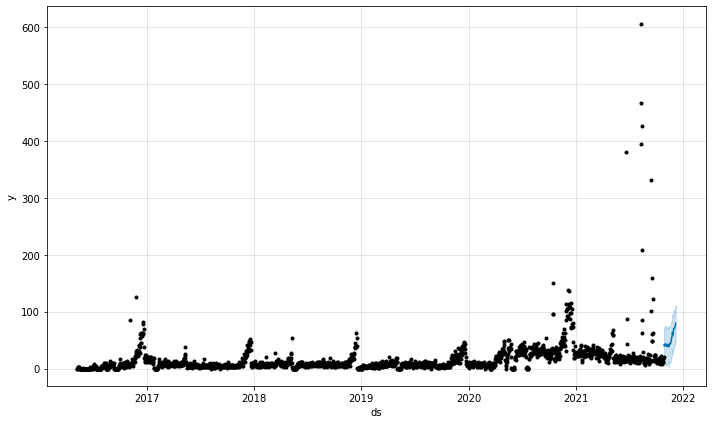

In [16]:
from fbprophet import Prophet
from pandas import to_datetime

predictions = []
temp = train_dataset.iloc[a]
temp2 = train_dataset.columns
temp3 = val_dataset.columns

df_x = pd.DataFrame(np.transpose([temp2, temp]))
df_x.columns = ["ds", "y"]
df_x["ds"]= to_datetime(df_x["ds"])
print("")
print("Train:")
print(df_x.head(6))

#holidays = pd.DataFrame({
#  'holiday': 'playoff',
#  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
#                        '2010-01-24', '2010-02-07', '2011-01-08',
#                        '2013-01-12', '2014-01-12', '2014-01-19',
#                        '2014-02-02', '2015-01-11', '2016-01-17',
#                        '2016-01-24', '2016-02-07']),
#  'lower_window': 0,
#  'upper_window': 1,
#})

#model = Prophet(seasonality_mode='multiplicative') #hoiidays=holidays
model = Prophet() #hoiidays=holidays

model.add_country_holidays(country_name='US')
print("HOLIDAYS LIST:")
model.fit(df_x)
print(model.train_holiday_names)

future = temp3
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])

#m = Prophet(seasonality_mode='multiplicative').fit(df_x)
#future = m.make_future_dataframe(periods=4 , freq='M')
#print("future is", future)
#fcst = m.predict(future)
#fig = m.plot(fcst)

print("")
print("Test:")
print(future.head(6))
forecast = model.predict(future)

print("")
print("Forecast:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(6))
print("")

#plot forecast
model.plot(forecast)
plt.show()

In [17]:
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.offline import iplot
import plotly.io as pio
pio.renderers.default='colab'

df_var = df_x

df_var['ds'] = pd.to_datetime(df_var['ds'])
weekly_df = df_var.resample('W', on='ds').apply(sum)
monthly_df = df_var.resample('M', on='ds').apply(sum)
daily_df = df_var.resample('D', on='ds').apply(sum)

# plotly.graph_objects
colors = px.colors.qualitative.Plotly
fig = go.Figure()
fig.add_traces(go.Scatter(x=pd.to_datetime(monthly_df.index.values), y = monthly_df['y'], mode = 'lines', line=dict(color=colors[2]), name = 'Monthly Bin'))
fig.add_traces(go.Scatter(x=pd.to_datetime(weekly_df.index.values), y = weekly_df['y'], mode = 'lines', line=dict(color=colors[1]), name = 'Weekly Bin'))
fig.add_traces(go.Scatter(x=pd.to_datetime(daily_df.index.values), y = daily_df['y'], mode = 'lines', line=dict(color=colors[0]), name = 'Daily Bin'))
product_name = str(df_new.SKU[b])
fig.update_layout(title_text='Daily/Weekly/Monthly Sales for Product '+product_name, title_x=0.5)

fig.show()

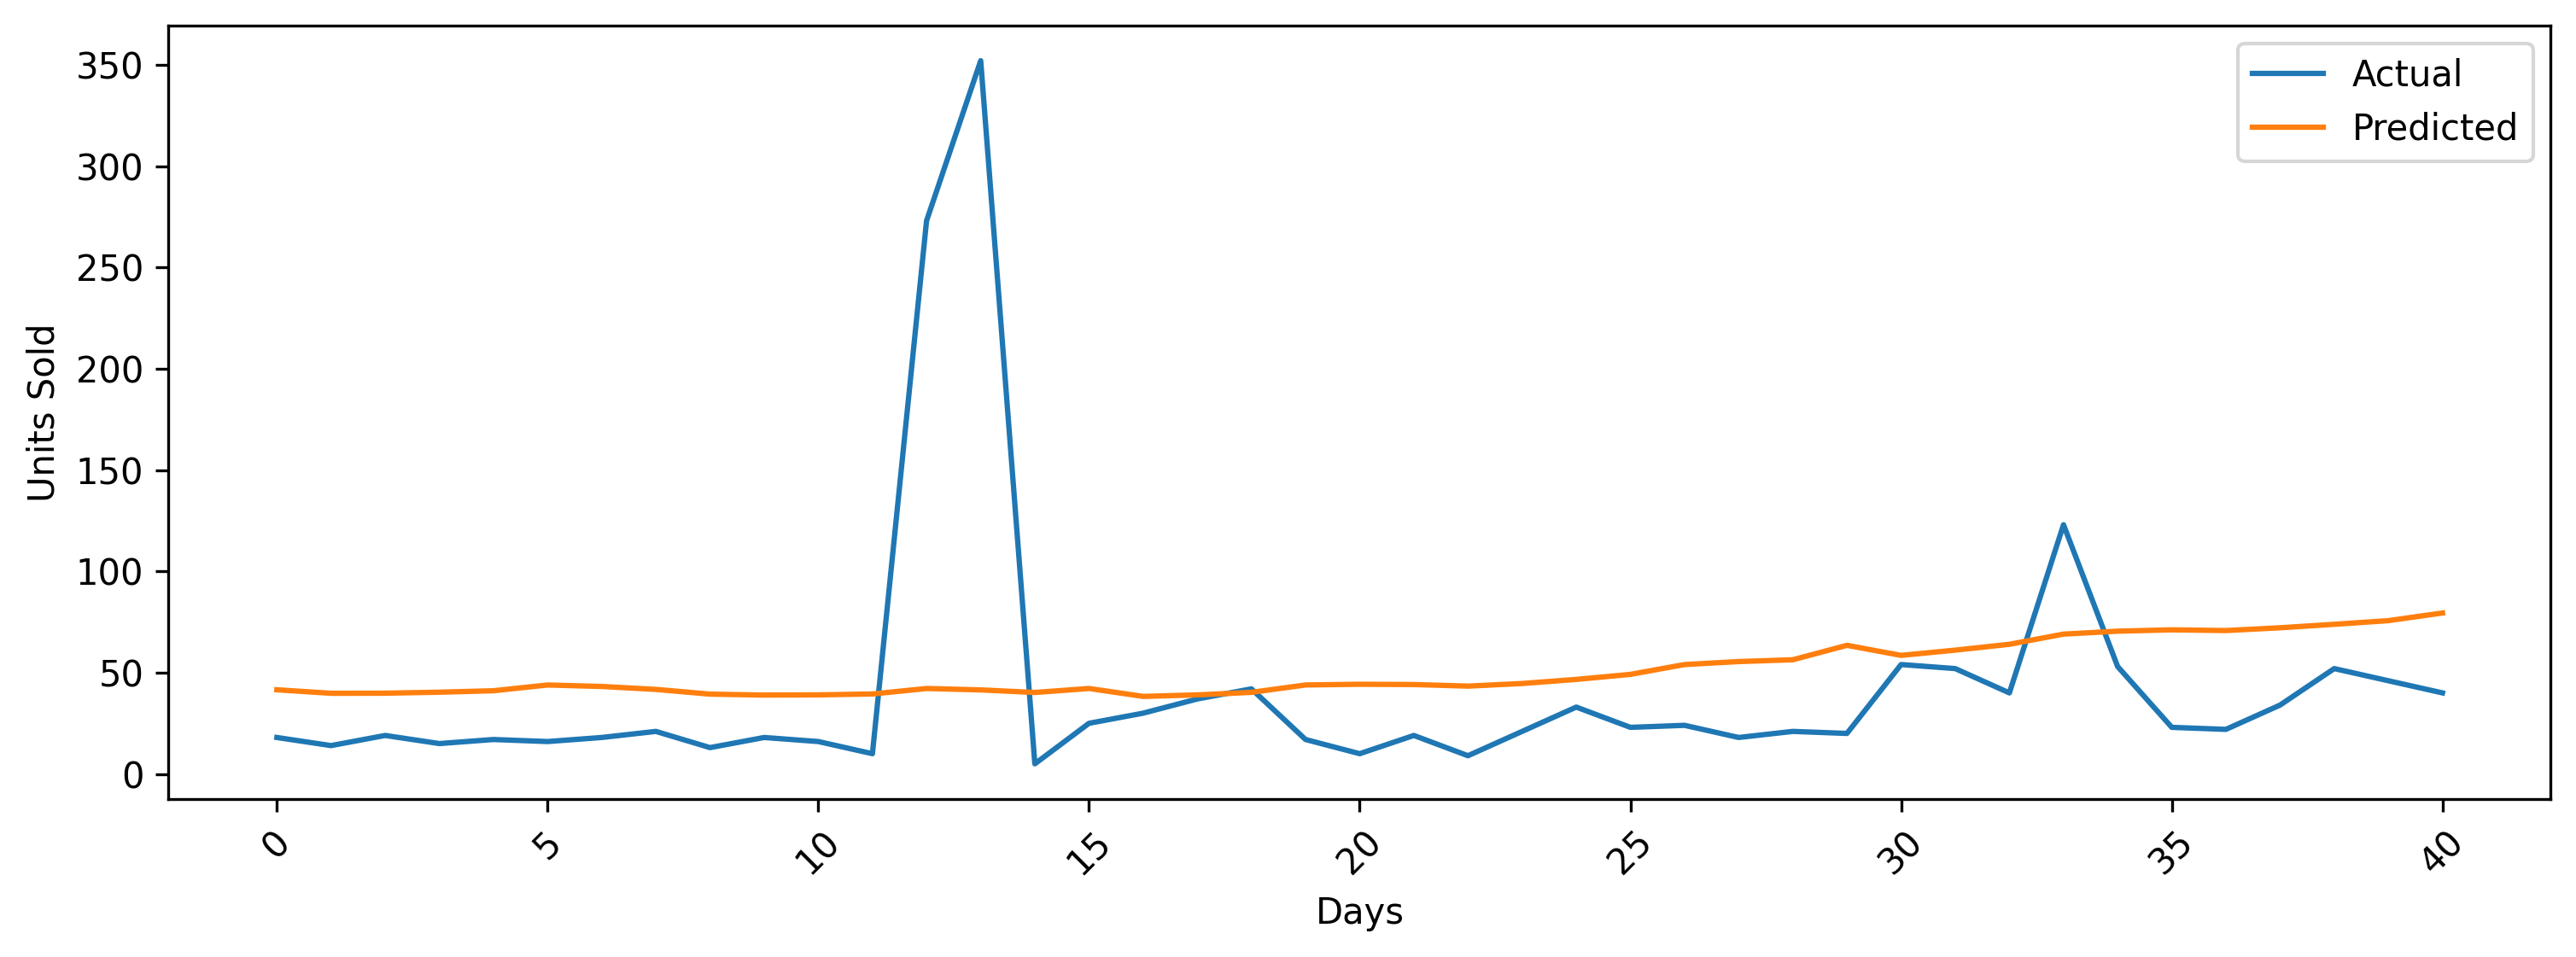

In [18]:
y_pred = forecast['yhat'].values
y_true = val_dataset.iloc[a]
y_true = y_true.tolist()
f = plt.figure(dpi=300)
f.set_figwidth(12)
f.set_figheight(4)
#print(y_true)
#print(y_pred)
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')

plt.xlabel('Days')
plt.ylabel('Units Sold')
plt.xticks(rotation = 45)
plt.legend()
plt.show()

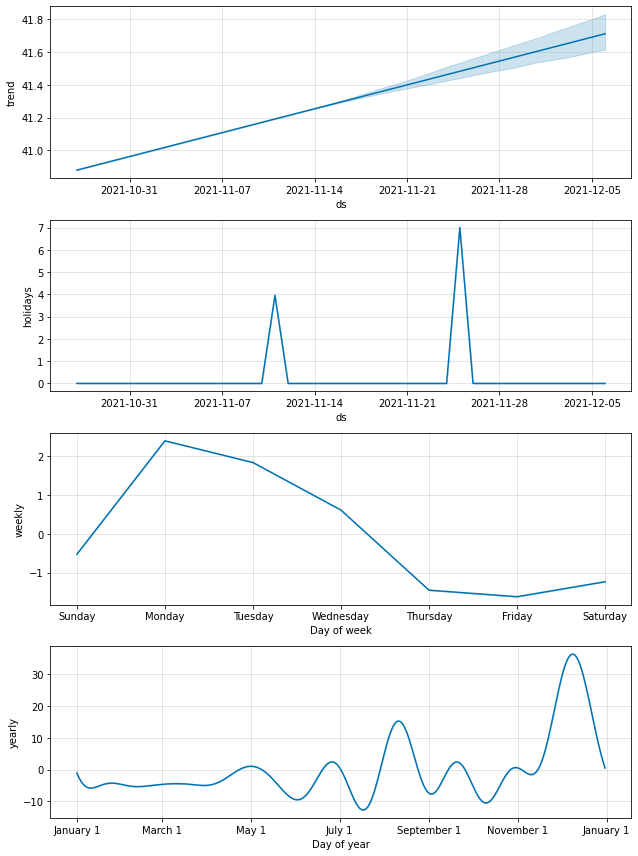

In [19]:
fig = model.plot_components(forecast)